> ![](https://raw.githubusercontent.com/SunnySuite/Sunny.jl/main/assets/sunny_logo.jpg)
_This is a [tutorial](https://github.com/SunnySuite/SunnyTutorials/tree/main/tutorials)
 for the [Sunny](https://github.com/SunnySuite/Sunny.jl/) package,
 which enables dynamical simulations of ordered and thermally disordered spins with dipole
 and higher order moments._

## Welcome to a Sunny Tutorial on the Diamond Lattice System CoRh<sub>2</sub>O<sub>4</sub>
**Script**: Diamond Lattice Finite Temperature Calculation <br>
**Inspired by**: CoRh<sub>2</sub>O<sub>4</sub> Powder
(Ge _et al._ https://doi.org/10.1103/PhysRevB.96.064413) <br>
**Authors**: Martin Mourigal, David Dahlbom <br>
**Date**: March 21, 2023  (Sunny 0.4.2) <br>
**Goal**: This script is to calculate the temperature dependence of the magnon excitations in the
spin-3/2 Heisenberg Diamond Antiferromagnet and compare to powder-averaged results obtained for
the compound CoRh<sub>2</sub>O<sub>4</sub> <br>

---
#### Loading Packages

In [1]:
using Sunny, GLMakie, ProgressMeter, Statistics, Random, Brillouin
Makie.inline!(true)
Sunny.offline_viewers()

cif_path = joinpath("..", "Sunny.jl", "examples", "longer_examples", "CoRh2O4_#109301.cif");

#### Defining Custom functions

The function `quench!` randomizes the spins of a given `SpinSystem`, fixes a
target temperature, and lets the system relax at this temperature for `nrelax`
integration steps.

In [2]:
function quench!(sys, integrator; kTtarget, nrelax)
    randomize_spins!(sys);
    integrator.kT = kTtarget;
    prog          = Progress(nrelax; dt=10.0, desc="Quenched and now relaxing: ", color=:green);
    for _ in 1:nrelax
        step!(sys, integrator)
        next!(prog)
    end
end

quench! (generic function with 1 method)

`dwell!` takes a `SpinSystem`, sets a target temperature, and has the system
dwell at this temperature for `ndwell` integration steps.

In [3]:
function dwell!(sys, integrator; kTtarget, ndwell)
    integrator.kT = kTtarget;
    prog          = Progress(ndwell; dt=10.0, desc="Dwelling: ", color=:green);
    for _ in 1:ndwell
        step!(sys, integrator)
        next!(prog)
    end
end

dwell! (generic function with 1 method)

`anneal!` takes a temperature schedule and cools the `SpinSystem` through it,
with `ndwell` steps of the integrator at each temperature in the schedule.
Returns the energy at the end of the dwell for each scheduled temperature.

In [4]:
function anneal!(sys,  integrator;  kTschedule, ndwell)
    nspins = prod(size(sys.dipoles));
    ensys  = zeros(length(kTschedule))
    prog   = Progress(ndwell*length(kTschedule); dt=10.0, desc="Annealing: ", color=:red);
    for (i, kT) in enumerate(kTschedule)
        integrator.kT = kT
        for _ in 1:ndwell
            step!(sys, integrator)
            next!(prog)
        end
        ensys[i] = energy(sys)
    end
    return ensys/nspins
end

anneal! (generic function with 1 method)

`sample_sf!` samples a structure factor, which may be either an instant or
dynamical structure factor. The integrator is run `ndecorr` times before each
one of the samples is taken.

In [5]:
function sample_sf!(sf, sys, integrator; nsamples, ndecorr)
    prog  = Progress(nsamples*ndecorr; dt=10.0, desc="Sampling SF: ", color=:red);
    for _ in 1:nsamples
        for _ in 1:ndecorr
            step!(sys, integrator)
            next!(prog)
        end
        add_sample!(sf, sys)    # Accumulate the newly sampled structure factor into `sf`
    end
end

sample_sf! (generic function with 1 method)

`powder_average` powder averages a structure factor. Works for both instant
and dynamical structure factors. To prevent smearing, removes Bragg peaks
before introducing energy broadening. Bragg peaks are added back at ω=0 after
broadening.

In [6]:
function powder_average(dsf, rs, density; η=0.1, mode=:perp, kwargs...)
    prog   = Progress(length(rs); dt=10., desc="Powder Averaging: ", color=:blue);
    output = zeros(Float64, length(rs), length(ωs(dsf)))
    for (i, r) in enumerate(rs)
        qs = spherical_shell(dsf, r, density)
        if length(qs) == 0
            qs = [[0., 0., 0.]] ## If radius is too small, just look at 0 vector
        end
        vals = intensities(dsf, qs, mode; kwargs...)
        bragg_idxs = findall(x -> x > maximum(vals)*0.9, vals)
        bragg_vals = vals[bragg_idxs]
        vals[bragg_idxs] .= 0
        vals = broaden_energy(dsf, vals, (ω,ω₀)->lorentzian(ω-ω₀, η))
        vals[bragg_idxs] .= bragg_vals
        output[i,:] .= mean(vals, dims=1)[1,:]
        next!(prog)
    end
    return output
end

powder_average (generic function with 1 method)

---
### System Definition for CoRh<sub>2</sub>O<sub>4</sub>

Define the crystal structure of CoRh$_2$O$_4$  in the conventional cell

In [7]:
xtal    = Crystal(cif_path ;symprec=1e-4)
magxtal = subcrystal(xtal,"Co1")
view_crystal(magxtal,6.0)
print_symmetry_table(magxtal, 4.0)

Atom 1
Type 'Co1', position [0, 0, 0], multiplicity 8
Allowed g-tensor: | A  0  0 |
                  | 0  A  0 |
                  | 0  0  A |
Allowed anisotropy in Stevens operators 𝒪[k,q]:
    c₁*(𝒪[4,0]+5𝒪[4,4]) +
    c₂*(𝒪[6,0]-21𝒪[6,4])

Sunny.Bond(1, 3, [0, 0, 0])
Distance 3.6784429025744, coordination 4
Connects 'Co1' at [0, 0, 0] to 'Co1' at [0.25, 0.25, 0.25]
Allowed exchange matrix: | A  B  B |
                         | B  A  B |
                         | B  B  A |



Define spin and g-factors

In [8]:
valg = 2.0
valS = 3/2;

Assign Local Hilbert Space

In [9]:
lhs  = [SpinInfo(1,S=valS;g=valg)]
ffs  = [FormFactor(1,"Co2")];

Create Spin System and Randomize it

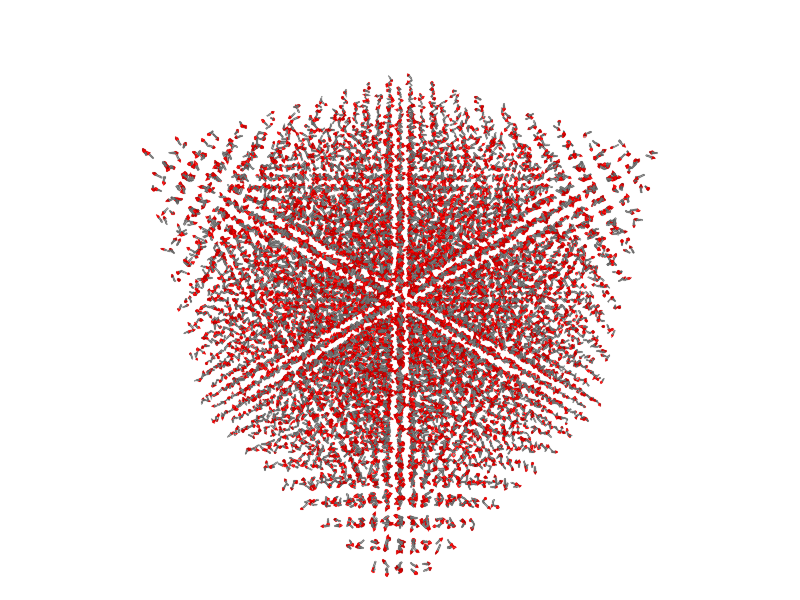

In [10]:
sunmode = :dipole
latsize = (10,10,10)
sys     = System(magxtal, latsize, lhs, sunmode; seed=1)
randomize_spins!(sys)
plot_spins(sys, arrowlength=1.0, linewidth=0.5, arrowsize=1.0)

Define Exchange Interactions

In [11]:
scaleJ = 0.63
valJ1  = 1.00*scaleJ
set_exchange!(sys, valJ1, Bond(1, 3, [0, 0, 0]) );

---
### System thermalization to an ordered, yet finite temperature, state

Define Langevin Integrator and Initialize it

In [12]:
Δt0           = 0.05/abs(scaleJ*valS); ## Time steps in Langevin
λ0            = 0.1; ## Langevin damping, usually 0.05 or 0.1 is good.
kT0           = 0.01*abs(scaleJ*valS); ## Initialize at some temperature
integrator    = Langevin(Δt0; λ=λ0, kT=kT0);

Thermalization
Option 1: Quench the system from infinite temperature to a target temperature.
Note: this may lead to a poorly thermalized sample

In [13]:
quench!(sys,integrator; kTtarget=kT0,nrelax=10000);

Option 2: Anneal (according to a temperature schedule) than dwell once reach base
Note: starting from very high temperature here

In [14]:
# kTs = [abs(scaleJ)*valS*100 * 0.9^k for k in 0:100];
# anneal!(sys,integrator;kTschedule=kTs,ndwell=500);
# dwell!(sys,integrator;kTtarget=kTs[end],ndwell=2000);

Plot the resulting spin system to check ordering in real space

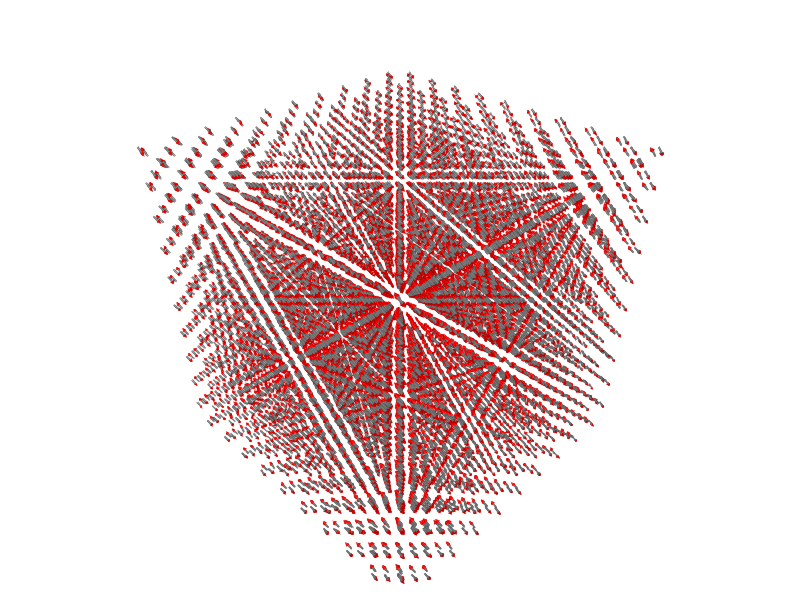

In [15]:
plot_spins(sys, arrowlength=1.0, linewidth=0.5, arrowsize=1.0)

---
### Calculation of Neutron Scattering Responses

#### Fourier transformed instantaneous two-point correlation functions

Calculate the Instantaneous/Equal-time Structure Factor

In [16]:
@time eqsf = InstantStructureFactor(sys);

  1.248207 seconds (10.80 M allocations: 503.325 MiB, 4.42% gc time, 98.93% compilation time)


If desired, add additional samples by decorrelating and then re-calculating the eqsf

In [17]:
nsamples   = 0;
ndecorr    = 1000;
@time sample_sf!(eqsf, sys, integrator; nsamples=nsamples, ndecorr=ndecorr);

  0.013383 seconds (32.71 k allocations: 1.755 MiB, 93.34% compilation time)


Project onto a constant Q-Slice in momentum space

In [18]:
nQpts  = 200;
Qxpts  = range(-10.0, 10.0, length=nQpts);
Qypts  = range(-10.0, 10.0, length=nQpts);
qz     = 1.0;
Qpts   = [[qx, qy, qz] for qx in Qxpts, qy in Qypts];
@time  iq = instant_intensities(eqsf, Qpts, :perp; interpolation = :none, kT=integrator.kT, formfactors=ffs);

  1.542677 seconds (11.18 M allocations: 830.157 MiB, 7.30% gc time, 87.41% compilation time)


Plot the resulting I(Q)

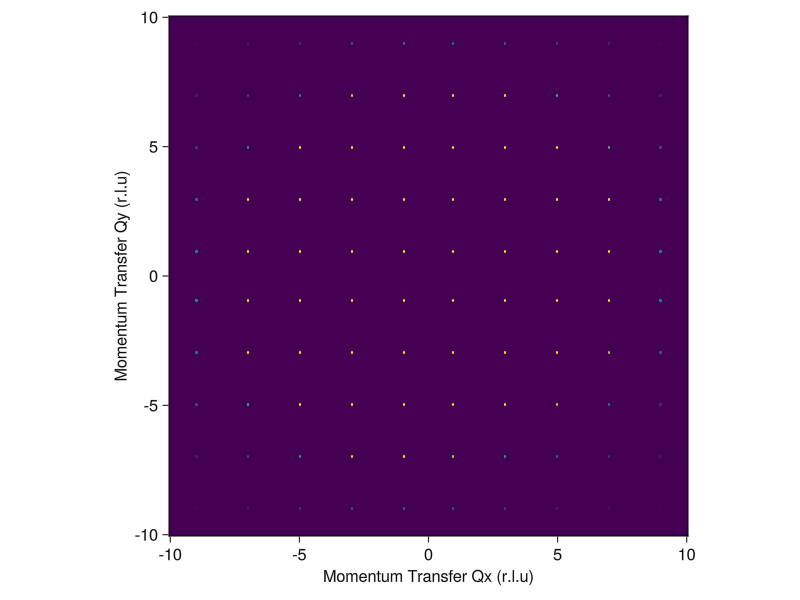

In [19]:
heatmap(Qxpts, Qypts, iq;
    colorrange = (0, maximum(iq)/20),
    axis = (
        xlabel="Momentum Transfer Qx (r.l.u)", xlabelsize=16,
        ylabel="Momentum Transfer Qy (r.l.u)", ylabelsize=16,
        aspect=true,
    )
)

#### Dynamical and energy-integrated two-point correlation functions

Calculate the Time Traces and Fourier Transform: Dynamical Structure Factor (first sample)

In [20]:
ωmax       = 6.0;  # Maximum  energy to resolve
nω         = 100;  # Number of energies to resolve
@time dsf  = DynamicStructureFactor(sys; Δt=Δt0, nω=nω, ωmax=ωmax, process_trajectory=:symmetrize);

 10.520297 seconds (153.13 M allocations: 10.634 GiB, 8.01% gc time, 1.79% compilation time)


If desired, add additional samples by decorrelating and then re-calculating the dsf

In [21]:
nsamples      = 0; # Aditional Samples
ndecorr       = 1000;
@time sample_sf!(dsf, sys, integrator; nsamples=nsamples, ndecorr=ndecorr);

  0.000073 seconds (11 allocations: 592 bytes)


Can use the Brillouin package for help on determining high symmetry points

In [22]:
kp        = irrfbz_path(227,[[1,0,0], [0,1,0], [0,0,1]]);
kpc       = cartesianize(kp)

KPath{3} (6 points, 2 paths, 8 points in paths):
 points: :U => [1.570796, 6.283185, 1.570796]
         :W => [3.141593, 6.283185, 0.0]
         :K => [4.712389, 4.712389, 0.0]
         :Γ => [0.0, 0.0, 0.0]
         :L => [3.141593, 3.141593, 3.141593]
         :X => [0.0, 6.283185, 0.0]
  paths: [:Γ, :X, :U]
         [:K, :Γ, :L, :W, :X]
  basis: [-6.283185, 6.283185, 6.283185]
         [6.283185, -6.283185, 6.283185]
         [6.283185, 6.283185, -6.283185]

Project onto a constant QE-Slice in momentum-energy space.

In [23]:
densQpts  = 50;
symQpts   = [[0.75, 0.75, 0.00],  # List of wave vectors that define a path
            [0.00, 0.00, 0.00],
            [0.50, 0.50, 0.50],
            [0.50, 1.00, 0.00],
            [0.00, 1.00, 0.00],
            [0.25, 1.00, 0.25],
            [0.00, 1.00, 0.00],
            [0.00,-4.00, 0.00]];
(Qpts, symQind) = connected_path(symQpts,densQpts);
@time  iqw = intensities(dsf, Qpts, :perp; interpolation = :none, kT=integrator.kT, formfactors=ffs);

  0.290569 seconds (1.32 M allocations: 117.462 MiB, 82.71% compilation time)


If desired, broaden the dsf in energy

In [24]:
η     = 0.02 ## Lorentzian energy broadening parameter
iqwc  = broaden_energy(dsf, iqw, (ω, ω₀) -> lorentzian(ω-ω₀, η));

If desired, calculated the energy-integrated structure factor

In [25]:
@time  iqt = instant_intensities(dsf, Qpts, :perp; interpolation = :none, kT=integrator.kT, formfactors=ffs);

  0.078574 seconds (687.78 k allocations: 86.814 MiB, 63.04% compilation time)


Plot the resulting I(Q,W)

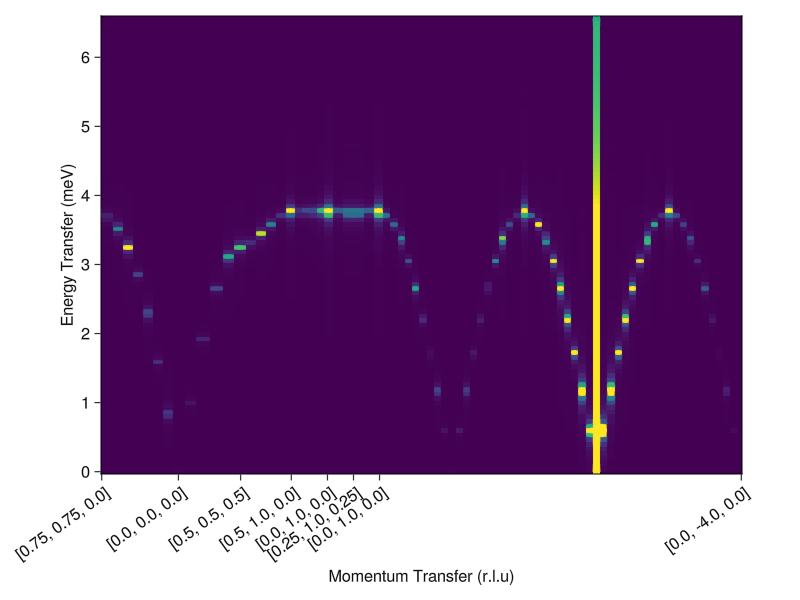

In [26]:
heatmap(1:size(iqwc, 1), ωs(dsf), iqwc;
    colorrange = (0, maximum(iqwc)/20000.0),
    axis = (
        xlabel="Momentum Transfer (r.l.u)",
        ylabel="Energy Transfer (meV)",
        xticks = (symQind, string.(symQpts)),
        xticklabelrotation=π/5,
        aspect = 1.4,
    )
)

Projection into a powder-averaged neutron scattering intensity

In [27]:
Qmax       = 3.5;
nQpts      = 100;
Qpow       = range(0, Qmax, length=nQpts);
η          = 0.1;
sphdensity = 3.5;
@time pqw = powder_average(dsf, Qpow, sphdensity; η, kT=integrator.kT, formfactors=ffs);

 44.202178 seconds (127.74 M allocations: 17.626 GiB, 2.55% gc time, 1.32% compilation time)


Plot resulting Ipow(Q,W)

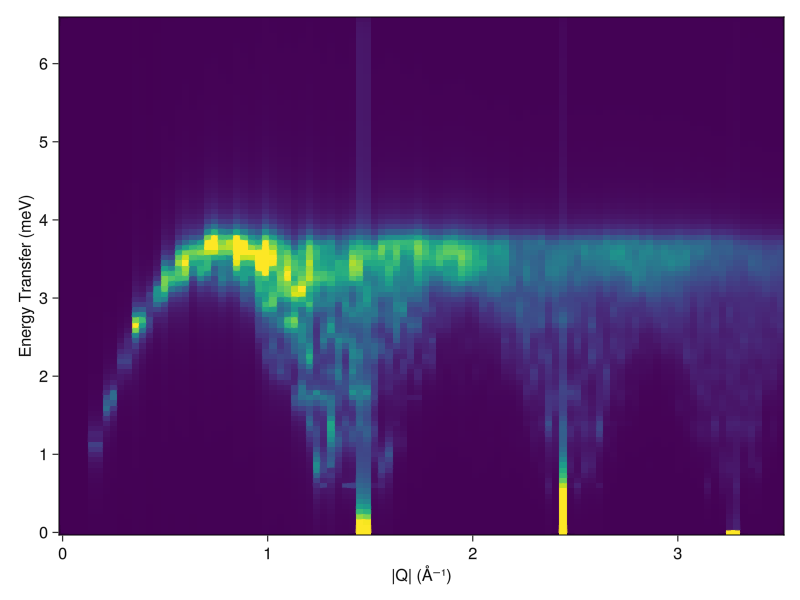

In [28]:
heatmap(Qpow, ωs(dsf), pqw;
    colorrange = (0, 20.0),
    axis = (
        xlabel="|Q| (Å⁻¹)",
        ylabel="Energy Transfer (meV)",
        aspect = 1.4,
    )
)

---
### Calculation of temperature-dependent powder average spectrum

Define a temperature schedule

In [29]:
kTs        = [60 40 25 20 15 12 10 4] * Sunny.meV_per_K;
pqw_res    = Array{Matrix{Float64}}(undef, length(kTs));
iqw_res    = Array{Matrix{Float64}}(undef, length(kTs));
for (i, kT) in enumerate(kTs)
    dwell!(sys, integrator;kTtarget=kT,ndwell=1000);
    dsf_loc     = DynamicStructureFactor(sys; Δt=2Δt0, nω=nω, ωmax=ωmax, process_trajectory=:symmetrize);
    iqw_res[i]  = intensities(dsf_loc, Qpts, :perp; interpolation = :none, kT=kT, formfactors=ffs);
    pqw_res[i]  = powder_average(dsf_loc, Qpow, sphdensity; η, kT=kT, formfactors=ffs);
end

Plot the resulting Ipow(Q,W) as a function of temperature,
to compare with Fig.6 of https://arxiv.org/abs/1706.05881

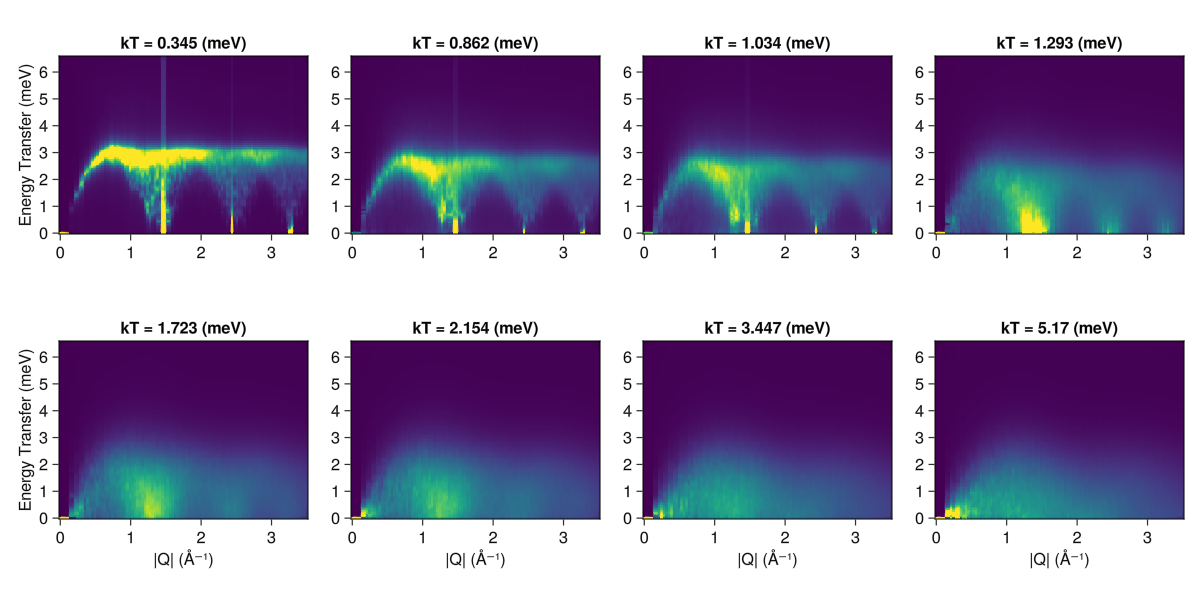

In [30]:
fig = Figure(; resolution=(1200,600))
for i in 1:8
    r, c = fldmod1(i, 4)
    ax = Axis(fig[r, c];
        title = "kT = "*string(round(kTs[9-i], digits=3))*" (meV)",
        xlabel = r == 2 ? "|Q| (Å⁻¹)" : "",
        ylabel = c == 1 ? "Energy Transfer (meV)" : "",
        aspect = 1.4,
    )
    heatmap!(ax, Qpow, ωs(dsf), pqw_res[9-i]; colorrange = (0, 10))
end
fig

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*